In [31]:
import os

from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from denovo_utils.analysis.metrics import load_seq_score_dicts
from denovo_utils.analysis.metrics import get_match_score_table, get_prc_curve

from psm_utils import Peptidoform
from tqdm import tqdm
from peak_pack.utils import calculate_ppm

from denovo_utils.io.read import load_psmlist

from Levenshtein import editops # To track actions for transpositions
from nltk import edit_distance # For Damerau–Levenshtein distance

# Goal of the notebook

Error locations:
- N-terminal or C-terminal? 
- In parts where there is no ion evidence ?

Error types:

- Is there a pattern on what the errors actually are? 
- Are specific amino acids always confused ? 
- Are some amino acids always swapped ? 
- What about the modifications ?

In [127]:
mapper = {
    "[+25.980265]-": "b",
    "[UNIMOD:1]-": "a",
    "[UNIMOD:5]-": "d",
    "[UNIMOD:385]-": "e",
    "Q[UNIMOD:7]": "q",
    "N[UNIMOD:7]": "n",
    "C[UNIMOD:4]": "c",
    "M[UNIMOD:35]": 'm',
    "S[UNIMOD:21]": 's',
    "T[UNIMOD:21]": 't',
    "Y[UNIMOD:21]": 'y',
    "L": "I"
}

def peptidoform_to_lstring(peptidoform, mapper):
    new_peptidoform = peptidoform.proforma
    for p, l in mapper.items():
        new_peptidoform = new_peptidoform.replace(p, l)
    return new_peptidoform.split('/')[0]

# 1. Load the data

In [128]:
root_results_dn = '/public/compomics3/Sam/PXD028735/QExactive/rescoring'
root_mgf = '/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted'
root_results_db = '/public/compomics3/Sam/PXD028735/QExactive/search_results/identification'
run_names = [
    'LFQ_Orbitrap_DDA_Ecoli_01',
    'LFQ_Orbitrap_DDA_Human_01',
    'LFQ_Orbitrap_DDA_QC_01',
    'LFQ_Orbitrap_DDA_Yeast_01'
]

engine_names = [
    # 'adanovo',
    # 'pihelixnovo',
    # 'piprimenovo',
    'casanovo',
    'instanovo',
    'contranovo',
    'novob',
    'pepnet',
]

runs = {}
for run_name in run_names:
    print(f"Run: {run_name}")
    run = Run(run_name)

    mgf_path = os.path.join(root_mgf, run_name + '.mgf')

    # Load a ground-truth
    psmlist_gt = load_psmlist(os.path.join(
        root_results_dn, run_name, 'psmlist', 'ground_truth.parquet'
    ))
    # parser = DenovoEngineConverter.select('sage')
    # psmlist_gt = parser.parse(
    #     result_path=os.path.join(root_results_db, run_name + '.sage.tsv'),
    #     mgf_path=mgf_path
    # )
    run.load_data(
        psmlist=psmlist_gt.get_rank1_psms(),
        score_names=[],
        is_ground_truth=True
    )

    # Load the de novo results
    for engine_name in engine_names:
        print(f'loading {engine_name}')
        dn_path = os.path.join(root_results_dn, run_name, 'psmlist', engine_name + '.parquet')
        
        psmlist_denovo = load_psmlist(psm_path=dn_path)
        
        # parser = DenovoEngineConverter.select(engine_name)
        # psmlist_denovo = parser.parse(
        #     result_path=os.path.join(root_results_dn, engine_name, run_name + f'.{engine_name}.some_extension'),
        #     mgf_path=mgf_path
        # )
        run.load_data(
            psmlist=psmlist_denovo,
            score_names=[],
            is_ground_truth=False
        )
    
    runs[run_name] = run

Run: LFQ_Orbitrap_DDA_Ecoli_01


100%|██████████| 24285/24285 [00:00<00:00, 59552.20it/s]


loading casanovo


100%|██████████| 61876/61876 [00:00<00:00, 130677.93it/s]


loading instanovo


100%|██████████| 61562/61562 [00:00<00:00, 141285.21it/s]


loading contranovo


100%|██████████| 30999/30999 [00:00<00:00, 128274.06it/s]


loading novob


100%|██████████| 61479/61479 [00:00<00:00, 140352.10it/s]


loading pepnet


100%|██████████| 62560/62560 [00:00<00:00, 149011.31it/s]


Run: LFQ_Orbitrap_DDA_Human_01


100%|██████████| 90817/90817 [00:01<00:00, 50911.09it/s]


loading casanovo


100%|██████████| 115362/115362 [00:01<00:00, 59811.24it/s]


loading instanovo


100%|██████████| 114725/114725 [00:15<00:00, 7254.57it/s] 


loading contranovo


100%|██████████| 57640/57640 [00:01<00:00, 57257.19it/s]


loading novob


100%|██████████| 114064/114064 [00:01<00:00, 63582.28it/s]


loading pepnet


100%|██████████| 118245/118245 [00:01<00:00, 65935.60it/s]


Run: LFQ_Orbitrap_DDA_QC_01


100%|██████████| 83941/83941 [00:01<00:00, 52655.04it/s]


loading casanovo


100%|██████████| 107203/107203 [00:01<00:00, 63258.52it/s]


loading instanovo


100%|██████████| 106604/106604 [00:01<00:00, 69081.36it/s]


loading contranovo


100%|██████████| 53533/53533 [00:00<00:00, 60212.92it/s]


loading novob


100%|██████████| 106075/106075 [00:01<00:00, 72535.30it/s]


loading pepnet


100%|██████████| 109340/109340 [00:01<00:00, 70183.62it/s]


Run: LFQ_Orbitrap_DDA_Yeast_01


100%|██████████| 67111/67111 [00:01<00:00, 61157.34it/s]


loading casanovo


100%|██████████| 102518/102518 [00:01<00:00, 91772.47it/s]


loading instanovo


100%|██████████| 101883/101883 [00:01<00:00, 90147.86it/s]


loading contranovo


100%|██████████| 51215/51215 [00:00<00:00, 84864.08it/s] 


loading novob


100%|██████████| 101183/101183 [00:01<00:00, 96485.15it/s]


loading pepnet


100%|██████████| 103785/103785 [00:01<00:00, 98189.10it/s]


Evaluate

In [129]:
for run in runs.values():
    for spectrum in tqdm(run.spectra.values()):
        spectrum.compare_gt(
            'score_ms2rescore',
            ignore_score=True
        )

100%|██████████| 43131/43131 [00:17<00:00, 2468.20it/s]


In [38]:
spectrum

Spectrum ID: controllerType=0 controllerNumber=1 scan=66857
Ground-truth: IPILLR/2 ({'peptide': {'sage': 0.9793421626091003}, 'aa': {}})
Candidates:
	LPLLLR/2 ({'peptide': {'casanovo': 0.9864637851715088}, 'aa': {'casanovo': (0.98492, 0.98833, 0.98905, 0.98919, 0.98906, 0.97648)}})
	LPLLLR/2 ({'peptide': {'instanovo': -0.02716885879635811}, 'aa': {}})
	LPLLLR/2 ({'peptide': {'novob': 0.9971590042114258}, 'aa': {}})
	LPLLLR/2 ({'peptide': {'pepnet': 0.9452999830245972}, 'aa': {'pepnet': [0.9999571, 0.9924597, 0.9558322, 0.99767417, 0.99956423, 0.99945015]}})

# 3. Calculate (Damerau)-levenshtein distance

In [130]:
for run_name, run in runs.items():
    for spectrum in tqdm(run.spectra.values()):
        peptidoform_gt = peptidoform_to_lstring(spectrum.psm_gt.peptidoform, mapper=mapper)
        for psm_candidate in spectrum.psm_candidates:
            peptidoform_candidate = peptidoform_to_lstring(psm_candidate.peptidoform, mapper=mapper)

            changes = editops(
                peptidoform_gt,
                peptidoform_candidate
            )
            damerau_L = edit_distance(
                s1=peptidoform_gt,
                s2=peptidoform_candidate,
                transpositions=True
            )
            
            psm_candidate.scores.add_score(
                score=len(changes),
                metadata='levenshtein',
                score_type='peptide'
            )
            psm_candidate.scores.add_score(
                score=damerau_L,
                metadata='damerau-levenshtein',
                score_type='peptide'
            )
            psm_candidate.swaps = changes

100%|██████████| 43131/43131 [00:36<00:00, 1191.10it/s]


# 4. Extract set of errors under closer investigation (<3 errors)

Make distinction between two amino acid errors and an error due to switching around two amino acid.

This can be defined with the Damerau variant.

In [131]:
import pandas as pd

levenshtein_df = []

for run in runs.values():
    for spectrum in run.spectra.values():
        for psm in spectrum.psm_candidates:
            entry = {
                'tool': psm.engine_name,
                'levenshtein': psm.scores.get_score('levenshtein'),
                'damerau-levenshtein': psm.scores.get_score('damerau-levenshtein'),
                'swaps': psm.swaps,
                'peptide_evidence': psm.peptide_evidence,
                'peptide_gt': spectrum.psm_gt.peptidoform
            }
            levenshtein_df.append(entry)

levenshtein_df = pd.DataFrame(levenshtein_df)

<Axes: xlabel='damerau-levenshtein', ylabel='percentage'>

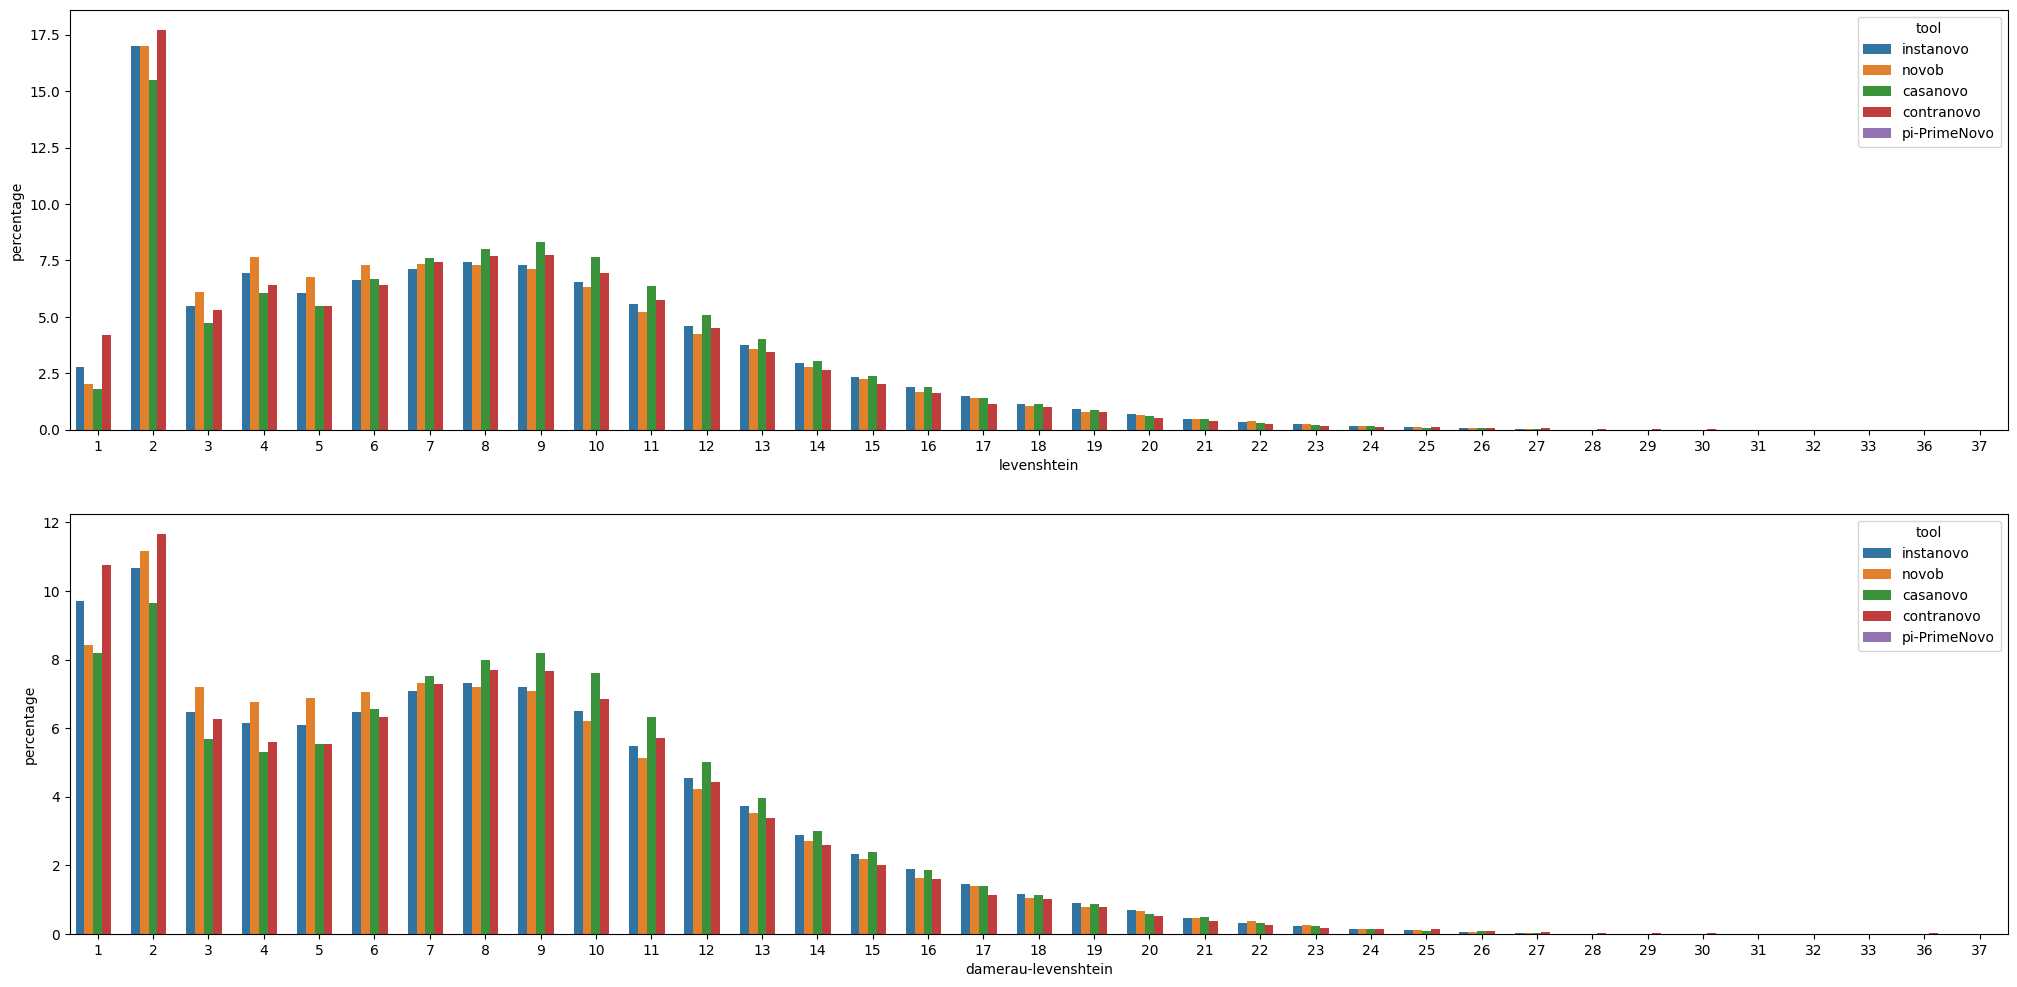

In [132]:
fig, ax = plt.subplots(2, 1, figsize=(25,12))

denovo_order = [
    # 'pepnet',
    # 'pi-HelixNovo',
    # 'AdaNovo',
    'instanovo',
    'novob',
    'casanovo',
    'contranovo',
    'pi-PrimeNovo'
]

normalized_df = (
    levenshtein_df[levenshtein_df['levenshtein'] > 0]
    .groupby(['tool', 'levenshtein'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

sns.barplot(
    normalized_df,
    x='levenshtein',
    y='percentage',
    hue='tool',
    hue_order=denovo_order,
    ax=ax[0]
)

normalized_df = (
    levenshtein_df[levenshtein_df['damerau-levenshtein'] > 0]
    .groupby(['tool', 'damerau-levenshtein'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

sns.barplot(
    normalized_df,
    y='percentage',
    x='damerau-levenshtein',
    hue='tool',
    hue_order=denovo_order,
    ax=ax[1]
)

<Axes: xlabel='damerau-levenshtein', ylabel='percentage'>

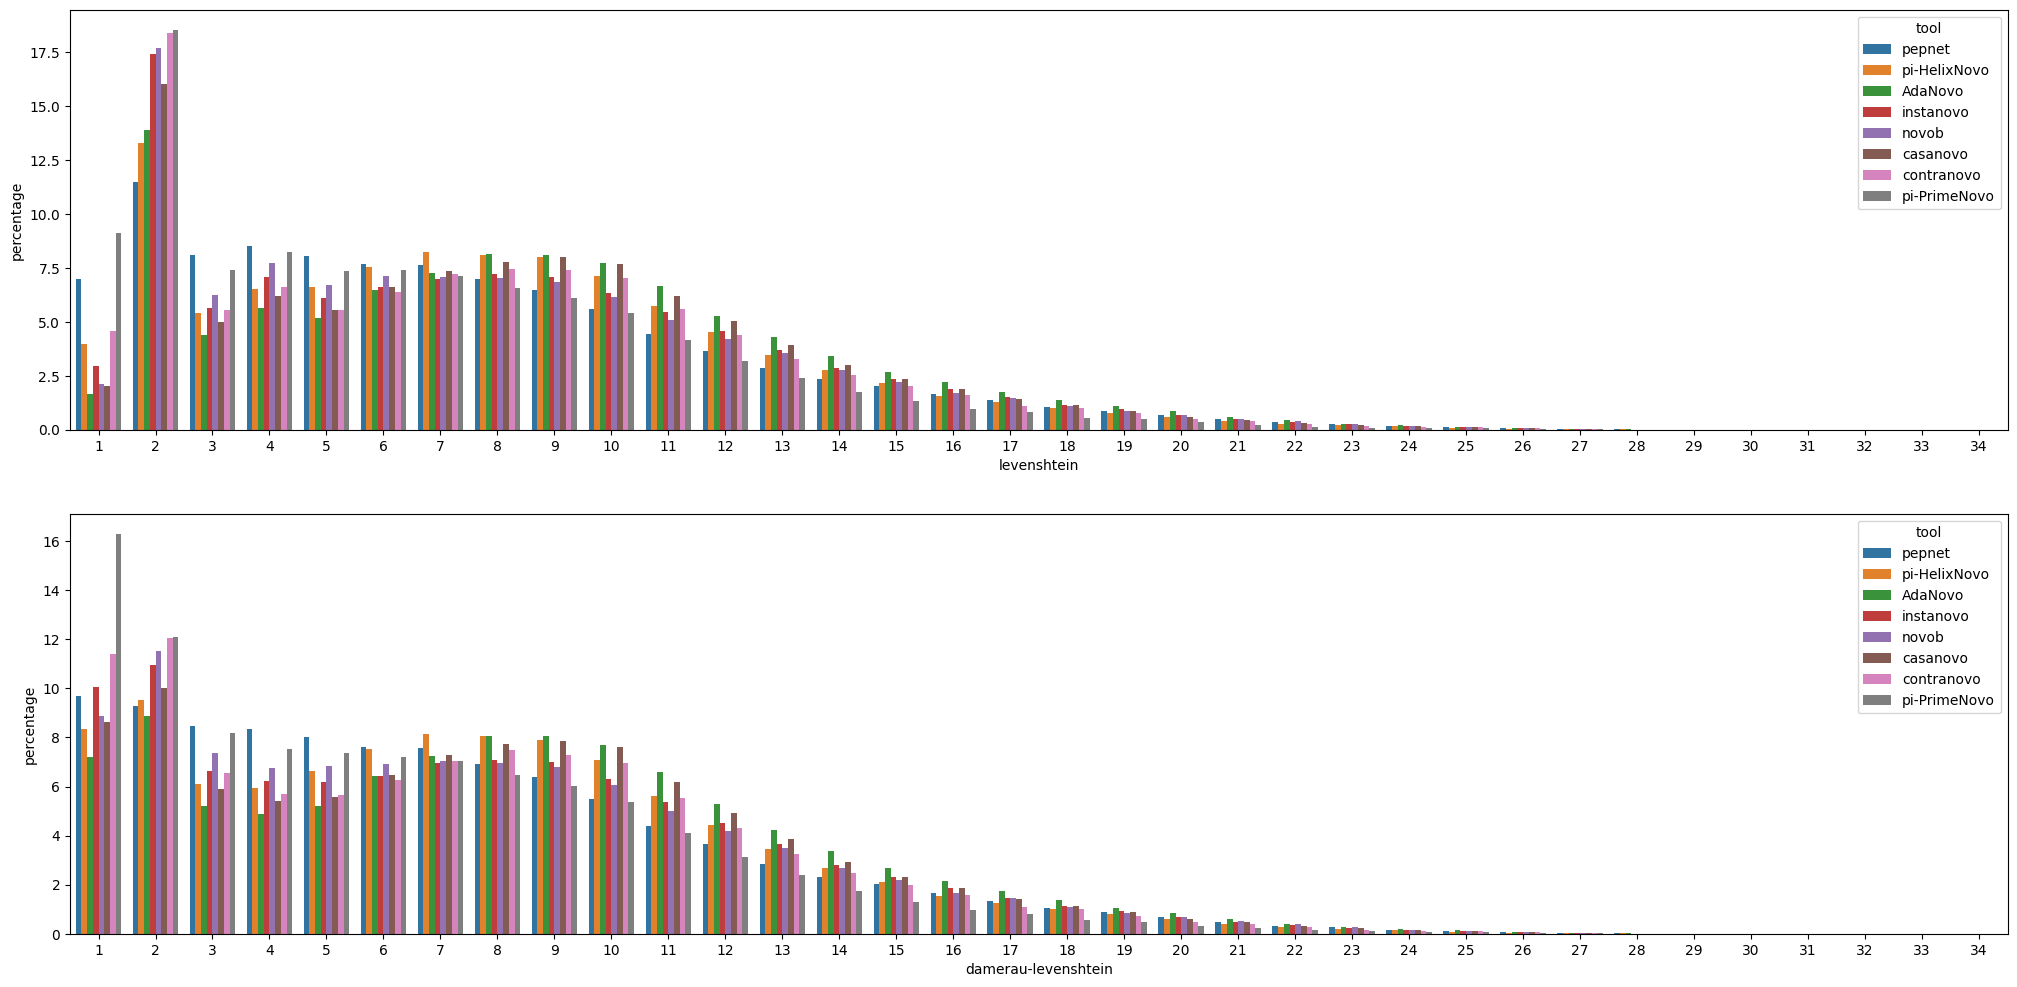

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(25,12))

denovo_order = [
    # 'pepnet',
    # 'pi-HelixNovo',
    # 'AdaNovo',
    'instanovo',
    'novob',
    'casanovo',
    'contranovo',
    'pi-PrimeNovo'
]

normalized_df = (
    levenshtein_df[levenshtein_df['levenshtein'] > 0]
    .groupby(['tool', 'levenshtein'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

sns.barplot(
    normalized_df,
    x='levenshtein',
    y='percentage',
    hue='tool',
    hue_order=denovo_order,
    ax=ax[0]
)

normalized_df = (
    levenshtein_df[levenshtein_df['damerau-levenshtein'] > 0]
    .groupby(['tool', 'damerau-levenshtein'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

sns.barplot(
    normalized_df,
    y='percentage',
    x='damerau-levenshtein',
    hue='tool',
    hue_order=denovo_order,
    ax=ax[1]
)

In [139]:
# N-term site (length from n-terminus)
# C-term site (length from c-terminus)
# In MF site

def insert(string, location, element):
    return string[:location] + element + string[location:]
def delete(string, location):
    return string[:location] + string[location+1:]
def replace(string, location, element):
    return string[:location] + element + string[location+1:]

def get_error_location(swaps, peptide_evidence, peptide_gt, log=False):
    pep_dn = peptidoform_to_lstring(peptide_evidence.peptidoform, mapper=mapper)
    pep_gt = peptidoform_to_lstring(peptide_gt, mapper=mapper)
    print(pep_gt)
    print(pep_dn)

    prev_index = 0
    replacements = []
    replacement_gt = ''
    replacement_dn = ''
    history = []
    
    for (action, index_gt, index_dn) in swaps:
        print(action, index_gt, index_dn)
        if (index_gt - prev_index != 1) and (prev_index != 0):
            replacements.append({
                'gt': replacement_gt,
                'dn': replacement_dn
            })
            replacement_gt = ''
            replacement_dn = ''

        if action == 'replace':    
            replacement_gt += pep_gt[index_gt]
            replacement_dn += pep_dn[index_dn]
            pep_dn = replace(pep_dn, index_dn, pep_gt[index_gt])

        elif action == 'delete':
            replacement_dn += pep_dn[index_dn]
            replacement_gt += pep_gt[index_gt]
            pep_dn = delete(pep_gt, index_gt)

        elif action == 'insert':
            replacement_gt += pep_gt[index_gt]
            replacement_dn += pep_dn[index_dn]
            pep_dn = insert(pep_dn, index_dn, pep_gt[index_gt])
            
        if log:
            print(pep_gt)
            print(pep_dn)
            print()
        
        prev_index = index_gt
    
    replacements.append({
        'gt': replacement_gt,
        'dn': replacement_dn
    })
    return replacements


In [123]:
levenshtein_df.loc[175]

tool                                                              pepnet
levenshtein                                                           18
damerau-levenshtein                                                   18
swaps                  [(replace, 2, 2), (replace, 3, 3), (delete, 4,...
peptide_evidence                      <TL><PSELLEPEAYVTLL><SQQAAAAQA>A/3
peptide_gt             ((T, None), (I, None), (I, None), (M, [UNIMOD:...
Name: 175, dtype: object

In [108]:
levenshtein_df['replacements'] = levenshtein_df.progress_apply(
    lambda x: get_error_location(
        swaps=x['swaps'],
        peptide_evidence=x['peptide_evidence'],
        peptide_gt=x['peptide_gt']
    ), axis=1
)

  0%|          | 175/835955 [00:00<17:39, 788.66it/s]


IndexError: string index out of range

In [118]:
editops(
    'TYPSELLEPEAYVTLLSQQAAAAQAA',
    'IIYTGPIDQYFDYR',
    
)

[('replace', 0, 0),
 ('replace', 1, 1),
 ('delete', 2, 2),
 ('delete', 3, 2),
 ('delete', 4, 2),
 ('delete', 5, 2),
 ('delete', 6, 2),
 ('delete', 7, 2),
 ('delete', 8, 2),
 ('delete', 9, 2),
 ('delete', 10, 2),
 ('delete', 12, 3),
 ('replace', 14, 4),
 ('replace', 15, 5),
 ('replace', 16, 6),
 ('replace', 17, 7),
 ('replace', 19, 9),
 ('replace', 20, 10),
 ('replace', 21, 11),
 ('replace', 22, 12),
 ('replace', 23, 13),
 ('delete', 24, 14),
 ('delete', 25, 14)]

In [120]:
swaps

[('replace', 2, 2),
 ('replace', 3, 3),
 ('delete', 4, 4),
 ('replace', 6, 5),
 ('replace', 7, 6),
 ('replace', 8, 7),
 ('replace', 9, 8),
 ('replace', 10, 9),
 ('insert', 12, 11),
 ('replace', 12, 12),
 ('replace', 14, 14),
 ('delete', 15, 15),
 ('delete', 16, 15),
 ('insert', 20, 18),
 ('replace', 22, 21),
 ('insert', 24, 23),
 ('delete', 26, 26),
 ('delete', 27, 26)]

In [140]:
(
    _,
    _,
    _,
    swaps,
    pe,
    gt
) = levenshtein_df.iloc[175].tolist()
get_error_location(
    swaps=swaps,
    peptide_evidence=pe,
    peptide_gt=gt,
    log=True
)

TIImDEQDHGYAITGDAISQAAIAAANR
TIPSEIIEPEAYVTIISQQAAAAQAA
replace 2 2
TIImDEQDHGYAITGDAISQAAIAAANR
TIISEIIEPEAYVTIISQQAAAAQAA

replace 3 3
TIImDEQDHGYAITGDAISQAAIAAANR
TIImEIIEPEAYVTIISQQAAAAQAA

delete 4 4
TIImDEQDHGYAITGDAISQAAIAAANR
TIImEQDHGYAITGDAISQAAIAAANR

replace 6 5
TIImDEQDHGYAITGDAISQAAIAAANR
TIImEQDHGYAITGDAISQAAIAAANR

replace 7 6
TIImDEQDHGYAITGDAISQAAIAAANR
TIImEQDHGYAITGDAISQAAIAAANR

replace 8 7
TIImDEQDHGYAITGDAISQAAIAAANR
TIImEQDHGYAITGDAISQAAIAAANR

replace 9 8
TIImDEQDHGYAITGDAISQAAIAAANR
TIImEQDHGYAITGDAISQAAIAAANR

replace 10 9
TIImDEQDHGYAITGDAISQAAIAAANR
TIImEQDHGYAITGDAISQAAIAAANR

insert 12 11
TIImDEQDHGYAITGDAISQAAIAAANR
TIImEQDHGYAIITGDAISQAAIAAANR

replace 12 12
TIImDEQDHGYAITGDAISQAAIAAANR
TIImEQDHGYAIITGDAISQAAIAAANR

replace 14 14
TIImDEQDHGYAITGDAISQAAIAAANR
TIImEQDHGYAIITGDAISQAAIAAANR

delete 15 15
TIImDEQDHGYAITGDAISQAAIAAANR
TIImDEQDHGYAITGAISQAAIAAANR

delete 16 15
TIImDEQDHGYAITGDAISQAAIAAANR
TIImDEQDHGYAITGDISQAAIAAANR

insert 20 18
TIImDEQDHGYAI

[{'gt': 'ImD', 'dn': 'PSE'},
 {'gt': 'QDHGY', 'dn': 'QDHGY'},
 {'gt': 'I', 'dn': 'I'},
 {'gt': 'I', 'dn': 'I'},
 {'gt': 'GDA', 'dn': 'GDA'},
 {'gt': 'A', 'dn': 'Q'},
 {'gt': 'I', 'dn': 'A'},
 {'gt': 'A', 'dn': 'A'},
 {'gt': 'NR', 'dn': 'AR'}]

In [95]:
get_error_location(
    swaps=swaps,
    peptide_evidence=pe,
    peptide_gt=pep_gt
)

Y


[{'gt': 'YR', 'dn': 'RY'}]

In [59]:
Peptidoform('LLYTGPLDQYFDRY')[12]

('R', None)

In [63]:
def insert(string, location, element):
    return string[:location] + element + string[location:]
def delete(string, location):
    return string[:location] + string[location+1:]

result = insert('IIYTGPIDQYFDYR', 12, "R")
delete(result, 14)

'IIYTGPIDQYFDRY'

In [64]:
result[14]

'R'

In [57]:
Peptidoform('IIYTGPIDQYFDYR/2')[14]

IndexError: list index out of range

In [45]:
levenshtein_df[levenshtein_df.levenshtein==2]

,tool,levenshtein,damerau-levenshtein,swaps,peptide_evidence,peptide_gt
11,novob,2,2,"[(replace, 2, 2), (delete, 3, 3)]",FC[UNIMOD:4]QEGLNNVLTLS<TF>R/2,"((F, None), (C, [UNIMOD:4]), (G, None), (A, No..."
35,pepnet,2,1,"[(insert, 12, 12), (delete, 13, 14)]",<LL>YTGPLDQYFD<RY>/2,"((I, None), (I, None), (Y, None), (T, None), (..."
36,casanovo,2,1,"[(insert, 10, 10), (delete, 11, 12)]",<GS>L<PL>ALDEV<TL>DGHK/3,"((G, None), (S, None), (I, None), (P, None), (..."
37,instanovo,2,1,"[(insert, 10, 10), (delete, 11, 12)]",<GS>L<PL>ALDEV<TL>DGHK/3,"((G, None), (S, None), (I, None), (P, None), (..."
41,casanovo,2,1,"[(insert, 12, 12), (delete, 13, 14)]",LVPFEDLPDEEV<SGR>/2,"((I, None), (V, None), (P, None), (F, None), (..."
...,...,...,...,...,...,...
835830,casanovo,2,1,"[(insert, 3, 3), (delete, 4, 5)]",<GV>EQLLK/2,"((G, None), (V, None), (E, None), (I, None), (..."
835831,instanovo,2,1,"[(insert, 3, 3), (delete, 4, 5)]",<GV>EQLLK/2,"((G, None), (V, None), (E, None), (I, None), (..."
835833,novob,2,2,"[(insert, 3, 3), (delete, 4, 5)]",GVEELLK/2,"((G, None), (V, None), (E, None), (I, None), (..."
835869,pepnet,2,2,"[(replace, 3, 3), (insert, 7, 7)]",<LREE><LEEY>YK/2,"((I, None), (R, None), (E, None), (Y, None), (..."


# 5. Find the locations

# 6. Find the exact amino acid error